# Lunar Lander

[Lunar Lander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) is a gym environment in which a "rocket"/lander is dropped from the top of the box region, and its task is to land the rocket safely (i.e. at a sufficiently moderate velocity) between two flagpoles. 

Four discrete actions are available to the lander: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.


In [2]:
import gym
import random
import numpy as np
import pandas as pd
from pylab import plt
from IPython import display
from collections import deque
plt.style.use('seaborn-v0_8')
import warnings; warnings.simplefilter('ignore')

import tensorflow.compat.v1 as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
tf.logging.set_verbosity(tf.logging.ERROR)

# Environment

In [3]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset()

(array([-1.3148307e-03,  1.3989749e+00, -1.3320298e-01, -5.3090233e-01,
         1.5304536e-03,  3.0172506e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

# Action Space

In [4]:
# Type of action space
env.action_space

# From 
# 0 = do nothing, 1 = fire left orientation engine, 2 = fire main engine, 3 = fire right orientation engine

# Note the action space was 2 for cart pole, 3 for mountain car, and 4 for lunar lander.

Discrete(4)

In [5]:
# Number of discrete actions
env.action_space.n

4

In [6]:
# Sample actions
[env.action_space.sample() for _ in range(10)]

[2, 2, 2, 1, 3, 2, 3, 3, 0, 2]

# Rewards

In [7]:
a = env.action_space.sample()
a

1

In [8]:
r = env.step(a)
r

(array([-0.00269051,  1.3864427 , -0.14059833, -0.5569896 ,  0.00454076,
         0.06021252,  0.        ,  0.        ], dtype=float32),
 -1.7883448033334435,
 False,
 False,
 {})

It is interesting to note that the reward here is a float, whereas in the previous OpenAI Gym exercises it has been an integer.

# Observation Space

In [9]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [10]:
env.observation_space.high

array([1.5      , 1.5      , 5.       , 5.       , 3.1415927, 5.       ,
       1.       , 1.       ], dtype=float32)

In [11]:
env.observation_space.low

array([-1.5      , -1.5      , -5.       , -5.       , -3.1415927,
       -5.       , -0.       , -0.       ], dtype=float32)

In [12]:
env.reset()
# [position, velocity]

(array([-0.00481291,  1.4101679 , -0.48750702, -0.03344014,  0.0055837 ,
         0.11042758,  0.        ,  0.        ], dtype=float32),
 {})

# Visualisation

# Visualising a Random Action Choice

Running the cell below will render an animation of the lunar lander's interaction with the environment as it performs a random action sample at each timestep.

*** FAILED ***


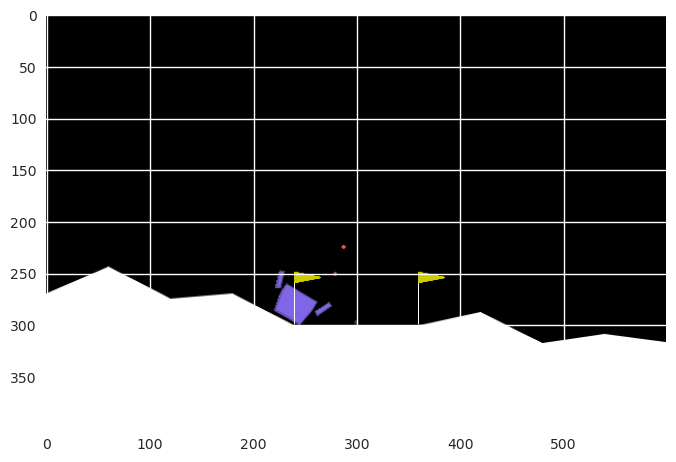

In [13]:
env.reset ()
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (201):
  img.set_data(env.render()) # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  a = env.action_space.sample() # random action choice
  # a = 2 # constant action choice
  obs, rew, done, _, _ = env.step(a) # taking action
  if done and (e + 1) < 200:
    print('*** FAILED ***')
    break

With random actions it is unspurprising that the agent doesn't manage to safely land between the flagpoles.

# Setting Seeds

In [14]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
    # env.seed(seed)

set_seeds()

# Q Learning

In [15]:
from collections import deque

class DQNAgent:
  def __init__(self):
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.gamma = 0.95
    self.batch_size = 128
    self.max_treward = -1e6
    self.averages = list()
    self.memory = deque(maxlen=2000)
    self.osn = env.observation_space.shape[0]
    self.model = self.create_model()

  def create_model(self):
    model = Sequential()
    model.add(Dense(1024, input_dim=self.osn, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return env.action_space.sample()
    action = self.model.predict(state, verbose=0)
    return np.argmax(action)
  
  def replay(self):
    print("Performing replay")
    batch = random.sample(self.memory, self.batch_size)
    for state, action, reward, next_state, done in batch:
      # Reward design
      reward -= np.mean(state[:1] ** 2) # Reward based on distance to origin
      if not done:
        reward += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
      target = self.model.predict(state, verbose=0)
      target[0, action] = reward
      self.model.fit(state, target, epochs=1, verbose=False)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
    print("Finished replay")

  def learn(self, episodes):
    trewards = []
    self.actions = []
    for e in range(1, episodes+1):
      state = env.reset()[0]
      state = np.reshape(state, [1, self.osn])
      treward = 0
      for time in range(5000):
        action = self.act(state)
        self.actions.append(action)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.reshape(next_state, [1, self.osn])
        self.memory.append([state, action, reward, next_state, done])
        state = next_state
        treward += float(reward)
        if done or truncated:
          trewards.append(treward)
          av = sum(trewards[:25]) / 25 # Work out a Rolling average
          self.averages.append(av)
          self.max_treward = max(self.max_treward, treward)
          print('Episode: {}/{},\ttreward: {},\tav: {:.2},\tmax_r: {:2}'.format(e,episodes, treward, av, self.max_treward))
          break
      if len(self.memory) > self.batch_size:
        self.replay()
      if treward > 200:
        break

  def test(self, episodes=100):
    trewards = []
    for e in range(1, episodes+1):
      print(f"{e=}")
      state = env.reset()[0]
      treward = 0
      for time in range(1001):
        state = np.reshape(state, [1, self.osn])
        action = np.argmax(self.model.predict(state, verbose=0)[0])
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        treward += reward
        if done or truncated or state[0] >= 0.5:
          trewards.append(treward)
          print('Episode: {}/{}, treward: {}, position: {}'.format(e, episodes, treward, state[0]))
          break
    return trewards

agent = DQNAgent()

2024-06-05 05:56:36.271783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
%time agent.learn(1000)

Episode: 1/1000,	treward: -129.21623805377635,	av: -5.2,	max_r: -129.21623805377635
Episode: 2/1000,	treward: -108.91163344707206,	av: -9.5,	max_r: -108.91163344707206
Performing replay
Finished replay
Episode: 3/1000,	treward: -131.20651419534263,	av: -1.5e+01,	max_r: -108.91163344707206
Performing replay
Finished replay
Episode: 4/1000,	treward: -240.39926143798297,	av: -2.4e+01,	max_r: -108.91163344707206
Performing replay
Finished replay
Episode: 5/1000,	treward: -435.0405082780169,	av: -4.2e+01,	max_r: -108.91163344707206
Performing replay
Finished replay
Episode: 6/1000,	treward: -133.25476671090456,	av: -4.7e+01,	max_r: -108.91163344707206
Performing replay
Finished replay
Episode: 7/1000,	treward: -90.73982414941626,	av: -5.1e+01,	max_r: -90.73982414941626
Performing replay
Finished replay
Episode: 8/1000,	treward: -384.7879447662381,	av: -6.6e+01,	max_r: -90.73982414941626
Performing replay
Finished replay
Episode: 9/1000,	treward: -426.10275495850647,	av: -8.3e+01,	max_r: -90

The training finished when the cart reached a position of > 0.5 distance units. A plot of final position vs. training episode is shown below.

In [ ]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='Moving average')
plt.plot(x, y, 'r-', label='regression')
plt.xlabel('episodes')
plt.ylabel('position value')
plt.legend()

[]


Based on the plot we can get a sense of whether the agent has reliably/incrementally "learned"/improved it's performance, or if it simply completed the task as a fluke.

# Testing the Agent

We test the agent to test if it has really "learned" the strategy to overcome the mountain, or rather managed to reach the finishing line by "chance".

In [ ]:
trewards, tpositions = agent.test(100)

e=1


Episode: 1/100, treward: -158.1946438489477, position: -0.3760891854763031
e=2
Episode: 2/100, treward: -144.71288152481478, position: 0.13613156974315643
e=3
Episode: 3/100, treward: -241.8986614514554, position: 0.34921950101852417
e=4
Episode: 4/100, treward: -150.61607333035806, position: -0.2880241274833679
e=5
Episode: 5/100, treward: -225.69546150289568, position: 0.5040483474731445
e=6
Episode: 6/100, treward: -168.300330533976, position: -0.4349389672279358
e=7
Episode: 7/100, treward: -122.24802377195084, position: -0.14157629013061523
e=8
Episode: 8/100, treward: -117.00407181106112, position: -0.21474996209144592
e=9
Episode: 9/100, treward: -142.6416200678372, position: -0.22454003989696503
e=10
Episode: 10/100, treward: -125.64733369159606, position: -0.25971388816833496
e=11
Episode: 11/100, treward: -112.86124576557529, position: -8.640289161121473e-05
e=12
Episode: 12/100, treward: -154.66269940803048, position: -0.2738047242164612
e=13
Episode: 13/100, treward: -164.9

KeyboardInterrupt: 

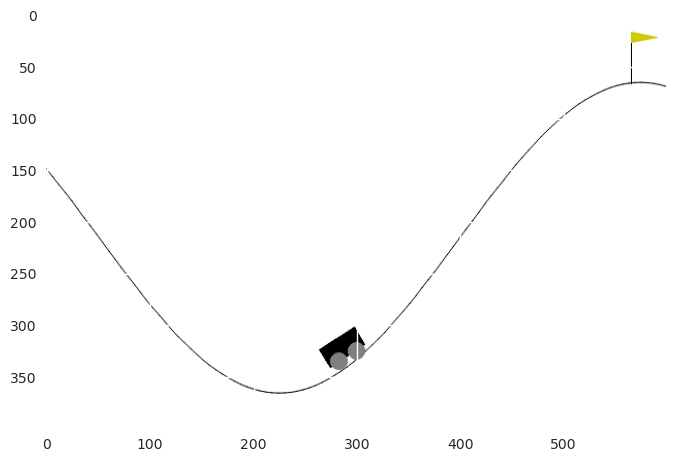

In [ ]:
state = env.reset(seed=0)[0]
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (201):
  img.set_data(env.render())  # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state = np.reshape(state, [1, agent.osn] )
  a = np.argmax(agent.model.predict(state, verbose=0))  # learned action
  state, reward, done, truncate, info = env.step(a)
  if done and (e + 1) < 200:
    print(f'*** SUCCESS {e} ***')
    break
  elif done:
    print('*** FAILED ***')
    break